In [4]:
import intake
from easygems import healpix as egh
from global_land_mask import globe
from scipy.interpolate import griddata
import intake
import cartopy.crs as ccrs
import uxarray as ux
import cartopy.feature as cf
import cmocean
import healpy as hp
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from scipy.spatial import KDTree
from icon_healpix import create_nc_files,plot_sfcwind_and_dup
import ifs_healpix

# Icon

In [2]:
lon_min,lon_max=330,40
lat_min,lat_max=0,50

In [6]:
def ifs_create_nc_files(level=11,lon_min=330,lon_max=40,lat_min=0,lat_max=50):
    cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")
    experiment = cat.online["ifs_tco3999-ng5_rcbmf_cf"]
    months=['Jan', 'Feb', 'Mar', 'Apr', 'May',"Jun", 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    data = experiment(time="PT1H", zoom=level).to_dask()#.chunk({"time": 1000})
    data = data.pipe(egh.attach_coords)
    for d_year in data.groupby("time.year"):
        for d in d_year[1].groupby("time.month"):
            vas=d[1].vas.where(((data["lat"] > lat_min) & (data["lat"] < lat_max))&((data["lon"] >lon_min) | (data["lon"] < lon_max)),drop=True)
            uas=d[1].uas.where(((data["lat"] > lat_min) & (data["lat"] < lat_max))&((data["lon"] >lon_min) | (data["lon"] < lon_max)),drop=True)
            sfc_wind=np.sqrt(uas**2+vas**2)
            U_t=7
            DUP=sfc_wind**3*(1+U_t/sfc_wind)*(1-U_t**2/sfc_wind**2)*(sfc_wind>U_t)
            sfc_wind_mean=sfc_wind.mean(dim="time").compute()
            DUP_mean=DUP.mean(dim="time").compute()
            month=months[sfc_wind[0].time.dt.month.values-1]
            year=sfc_wind[0].time.dt.year.values
            sfc_wind_mean.expand_dims(time=[sfc_wind[0].time.values]).to_dataset(name="sfcwind").to_netcdf("ifs_healpix/ws"+str(level)+"_mean_"+month+"_"+str(year)+".nc", mode="w")
            DUP_mean.expand_dims(time=[sfc_wind[0].time.values]).to_dataset(name="dup").to_netcdf("ifs_healpix/dup"+str(level)+"_mean_"+month+"_"+str(year)+".nc", mode="w")
            del DUP,sfc_wind,DUP_mean,sfc_wind_mean

In [8]:
ifs_create_nc_files(level=11)

/home/b/b383063/.local/share/mamba/envs/easy/lib/python3.12/site-packages/intake_xarray/xzarr.py:46: UserWarning: The specified chunks separate the stored chunks along dimension "cell" starting at index 33554432. This could degrade performance. Instead, consider rechunking after loading.
  self._ds = xr.open_dataset(self.urlpath, **kw)
/home/b/b383063/.local/share/mamba/envs/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


KeyboardInterrupt: 

## different levels

In [112]:
create_nc_files(level=9)

/home/b/b383063/.local/share/mamba/envs/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [113]:
create_nc_files(level=7)

/home/b/b383063/.local/share/mamba/envs/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [ ]:
# Make plots

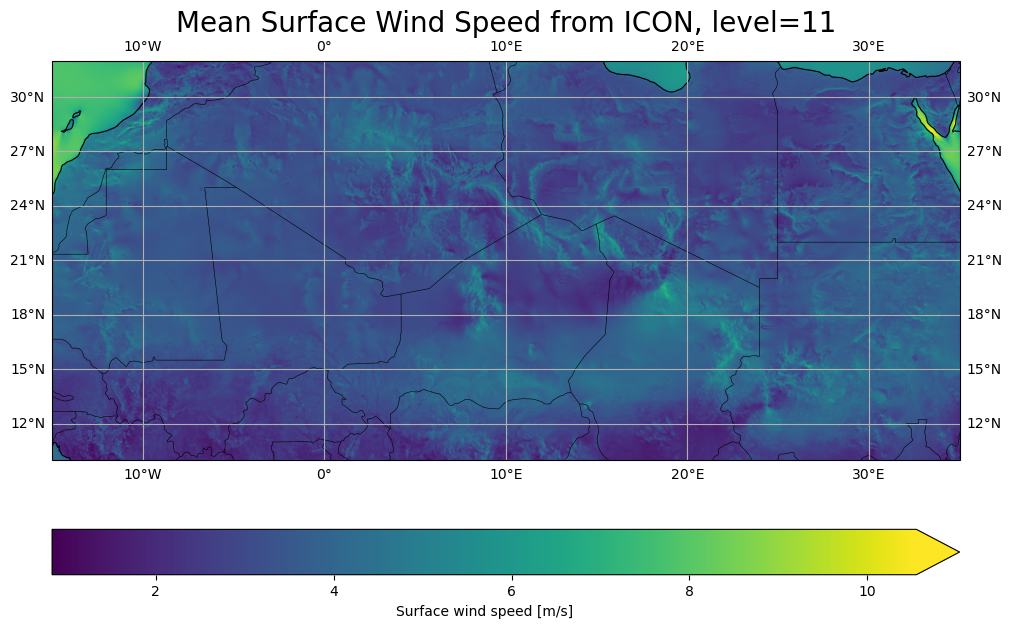

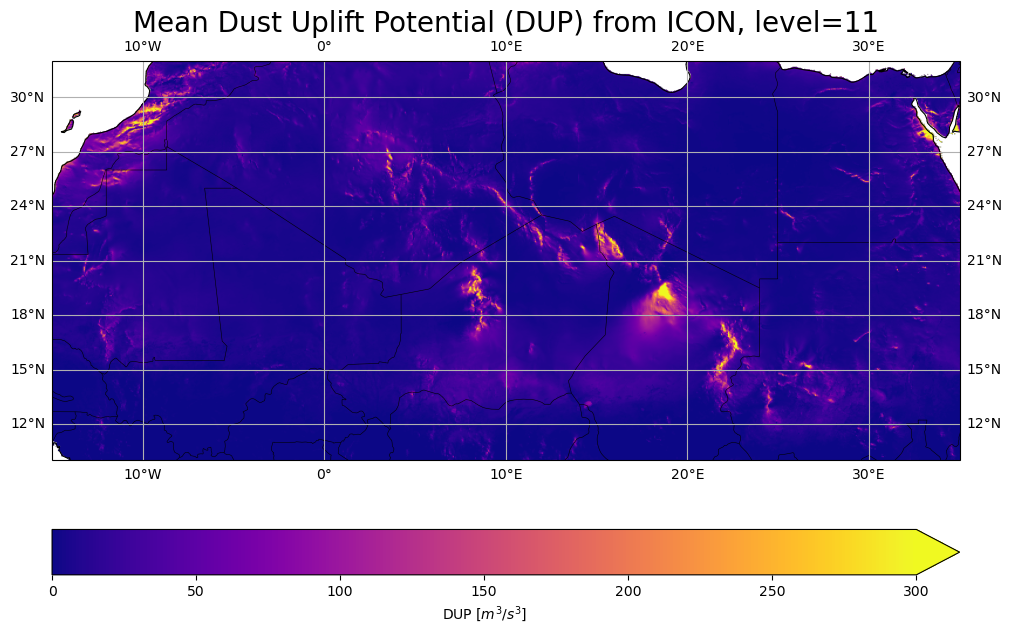

In [3]:
plot_sfcwind_and_dup(level=11)

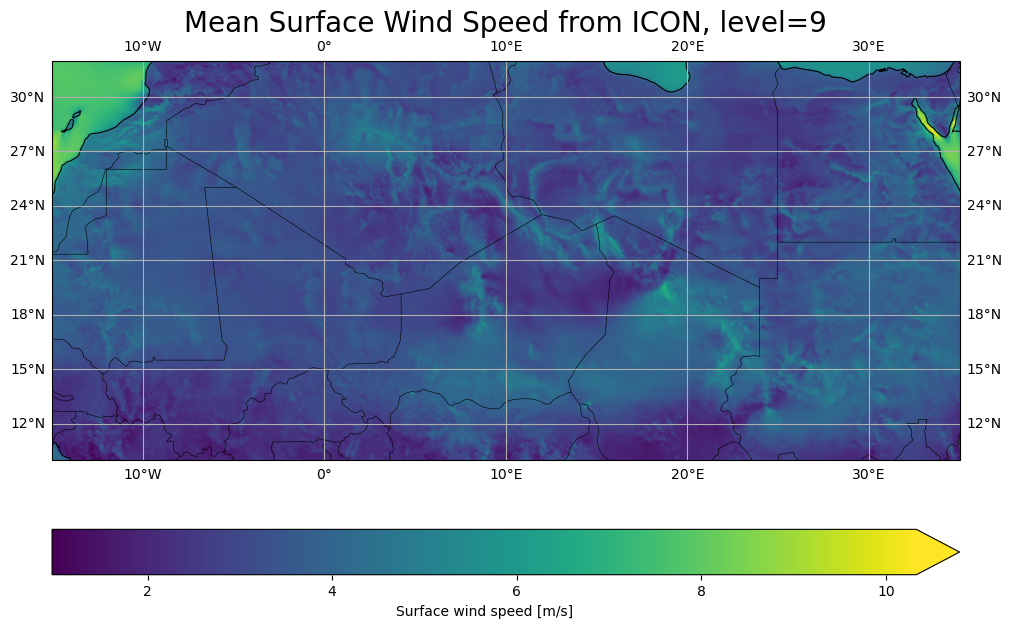

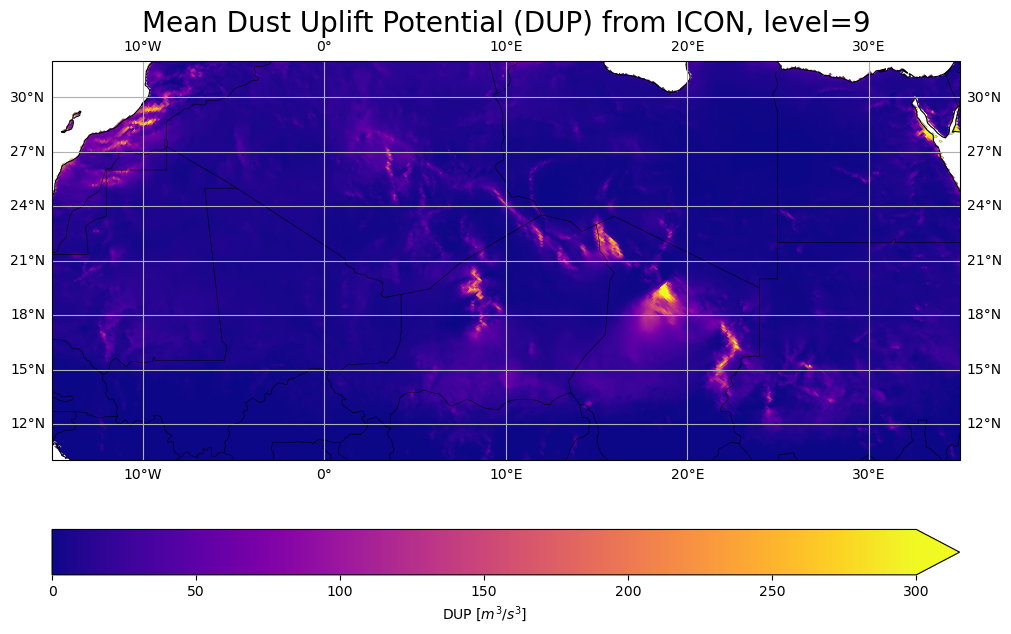

In [4]:
plot_sfcwind_and_dup(level=9)

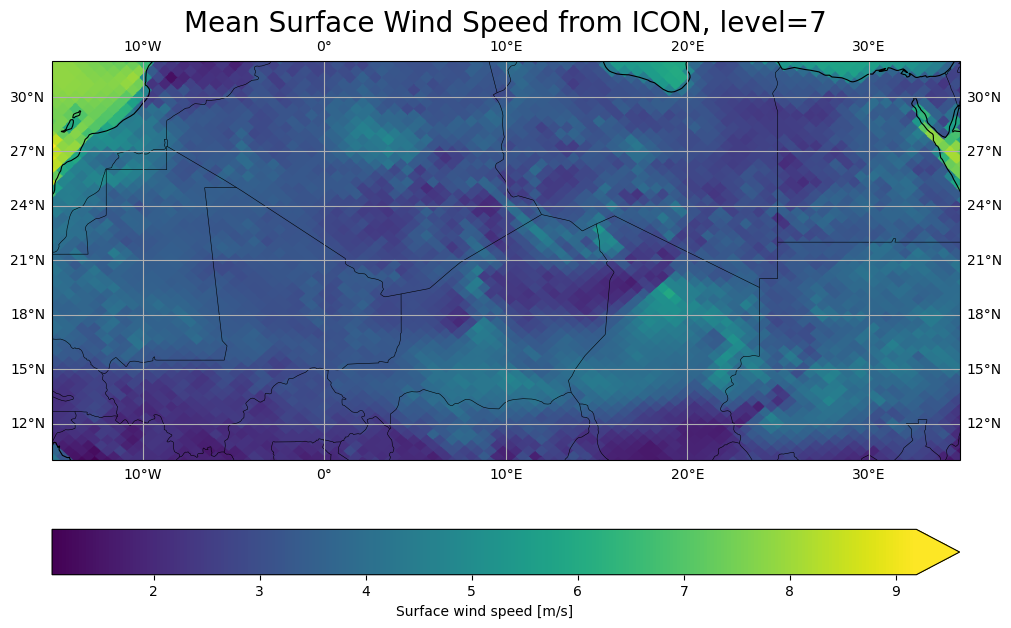

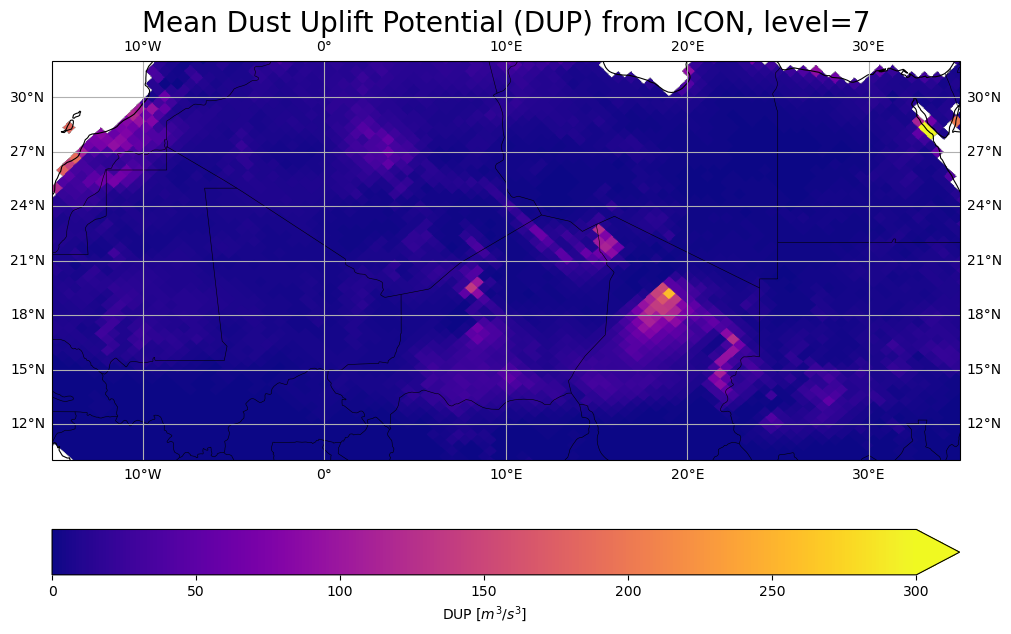

In [5]:
plot_sfcwind_and_dup(level=7)

# ERA5

In [11]:
import healpix as hp
import numpy as np
import xarray as xr
import dask
import easygems.healpix as egh
import easygems.remap as egr
import matplotlib.pyplot as plt

In [7]:
zoom=7

In [51]:
era5_create_nc_files(level=zoom)

In [8]:
DUP_mean = xr.open_mfdataset(f"icon_healpix/dup9*.nc")#.mean(dim="time").compute().coarsen(cell=16,boundary="trim").mean()

In [9]:
DUP_mean_c=xr.open_mfdataset(f"icon_healpix/dup7*.nc").mean(dim="time").compute()

In [12]:
def get_nn_data(var, nx=1000, ny=1000, ax=None):
    """
    var: variable (array-like)
    nx: image resolution in x-direction
    ny: image resolution in y-direction
    ax: axis to plot on
    returns: values on the points in the plot grid.
    """
    lonlat = get_lonlat_for_plot_grid(nx, ny, ax)
    try:
        return get_healpix_nn_data(var, lonlat)
    except ValueError:
        pass
    if set(var.dims) == {"lat", "lon"}:
        return get_lonlat_meshgrid_nn_data(var, lonlat)
    else:
        return get_lonlat_nn_data(var, lonlat)


def get_healpix_nn_data(var, lonlat):
    """
    var: variable on healpix coordinates (array-like)
    lonlat: coordinates at which to get the data
    returns: values on the points in the plot grid.
    """
    valid = np.all(np.isfinite(lonlat), axis=-1)
    points = lonlat[valid].T  # .T reverts index order
    pix = hp.ang2pix(
        hp.npix2nside(len(var)), theta=points[0], phi=points[1], nest=True, lonlat=True
    )
    res = np.full(lonlat.shape[:-1], np.nan, dtype=var.dtype)
    res[valid] = var[pix]
    return res


def get_lonlat_nn_data(var, lonlat):
    """
    var: variable with lon and lat attributes (2d slice)
    lonlat: coordinates at which to get the data
    returns: values on the points in the plot grid.
    """
    var_xyz = lonlat_to_xyz(lon=var.lon.values.flatten(), lat=var.lat.values.flatten())
    tree = KDTree(var_xyz)

    valid = np.all(np.isfinite(lonlat), axis=-1)
    ll_valid = lonlat[valid].T
    plot_xyz = lonlat_to_xyz(lon=ll_valid[0], lat=ll_valid[1])

    distances, inds = tree.query(plot_xyz)
    res = np.full(lonlat.shape[:-1], np.nan, dtype=var.dtype)
    res[valid] = var.values.flatten()[inds]
    return res


def get_lonlat_meshgrid_nn_data(var, lonlat):
    """
    var: variable with lon and lat attributes (2d slice)
    lonlat: coordinates at which to get the data
    returns: values on the points in the plot grid.
    """
    return get_lonlat_nn_data(var.stack(cell=("lon", "lat")), lonlat)


def get_lonlat_for_plot_grid(nx, ny, ax=None):
    """
    nx: image resolution in x-direction
    ny: image resolution in y-direction
    ax: axis to plot on
    returns: coordinates of the points in the plot grid.
    """

    if ax is None:
        ax = plt.gca()

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    xvals = np.linspace(xlims[0], xlims[1], nx)
    yvals = np.linspace(ylims[0], ylims[1], ny)
    xvals2, yvals2 = np.meshgrid(xvals, yvals)
    lonlat = ccrs.PlateCarree().transform_points(
        ax.projection, xvals2, yvals2, np.zeros_like(xvals2)
    )
    return lonlat


def lonlat_to_xyz(lon, lat):
    """
    lon: longitude in degree E
    lat: latitude in degree N
    returns numpy array (3, len (lon)) with coordinates on unit sphere.
    """

    return np.array(
        (
            np.cos(np.deg2rad(lon)) * np.cos(np.deg2rad(lat)),
            np.sin(np.deg2rad(lon)) * np.cos(np.deg2rad(lat)),
            np.sin(np.deg2rad(lat)),
        )
    ).T

In [13]:
def plot_map_diff(var, ref, colorbar_label="", title="", extent=None,ax=None,cmap="viridis",
                  interpolation=None,vmin=None,vmax=None):
    """
    var: data set
    ref: reference data
    colorbar_label: label for the colorbar
    title: title string
    **kwargs: get passed to imshow
    returns figure, axis objects
    """
    projection = crs=ccrs.PlateCarree()
    ax.set_global()
    if extent is not None:
        ax.set_extent(extent, crs=ccrs.PlateCarree())

    varmap = get_nn_data(var, ax=ax)
    refmap = get_nn_data(ref, ax=ax)
    imsh = ax.imshow(
        varmap - refmap, extent=ax.get_xlim() + ax.get_ylim(), origin="lower",cmap=cmap,vmin=vmin,vmax=vmax,interpolation=interpolation,
    )
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)
    #fig.colorbar(imsh, label=colorbar_label)
    plt.title(title)
    return imsh

NameError: name 'zoom' is not defined

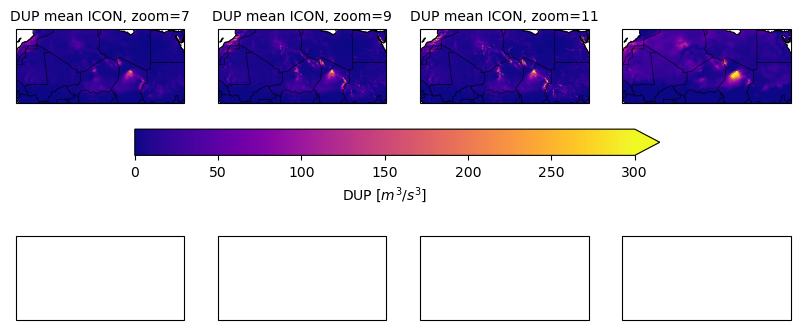

In [14]:
# Liste deiner Levels
levels = [7,9,11]  # Beispielwerte – passe an

# Erstelle Figure und 3 Subplots mit Kartenprojektion
fig, axes = plt.subplots(
    nrows=2, ncols=4,
    figsize=(10, 5),
    subplot_kw={"projection": ccrs.PlateCarree()},
)

# Maximalwert für Farbskala definieren (gleich für alle Plots)
vmax = 300

# Schleife über Levels und Achsen
for level, ax in zip(levels, axes[0,:-1]):
    # Daten laden und mitteln
    DUP_mean = xr.open_mfdataset(f"icon_healpix/dup{level}*.nc").mean(dim="time").compute()

    # Landmaske berechnen
    land_mask = ~globe.is_ocean(DUP_mean.lat, ((DUP_mean.lon + 180) % 360) - 180)

    # Kartenausschnitt setzen
    ax.set_extent([-15, 35, 10, 32], crs=ccrs.PlateCarree())
    #ax.set_extent([15, 20, 15, 20], crs=ccrs.PlateCarree())

    # Plotten mit deiner Funktion (vermutlich healpix_show)
    im = egh.healpix_show(DUP_mean.dup.where(land_mask), ax=ax, cmap="plasma", vmax=vmax)#

    # Karten-Features hinzufügen
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)

    # Titel für jedes Subplot
    ax.set_title(f"DUP mean ICON, zoom={level}", fontsize=10)


# Gemeinsame Farbleiste unten
fig.colorbar(im, ax=axes[0,:], orientation='horizontal', location="bottom",
                    label=r"DUP [$m^3/s^3$]", extend="max")

axes[0,-1].set_extent([-15, 35, 10, 32], crs=ccrs.PlateCarree())#[-15, 35, 10, 32]

era5_DUP_mean = xr.open_mfdataset("era5_healpix/era5_dup*.nc").mean(dim="time").compute()
land_mask_era5 = ~globe.is_ocean(era5_DUP_mean.lat, ((era5_DUP_mean.lon + 180) % 360) - 180)
egh.healpix_show(era5_DUP_mean.dup.where(land_mask_era5), ax=axes[0,-1], cmap="plasma", vmax=vmax)#
axes[0,-1].add_feature(cf.COASTLINE, linewidth=0.8)
axes[0,-1].add_feature(cf.BORDERS, linewidth=0.4)
axes[0,-1].set_title(f"DUP mean ERA5,zoom="+str(zoom), fontsize=10)
# Calculate the difference
for level, ax in zip(levels, axes[1,:-1]):
    # Daten laden und mitteln
    DUP_mean = xr.open_mfdataset(f"icon_healpix/dup{level}*.nc").mean(dim="time").compute()
    DUP_mean.coarsen(cell=int(4**(level-7)),boundary="trim").mean()
    # Landmaske berechnen
    land_mask = ~globe.is_ocean(DUP_mean.lat, ((DUP_mean.lon + 180) % 360) - 180)

    # Kartenausschnitt setzen
    ax.set_extent([-15, 35, 10, 32], crs=ccrs.PlateCarree())

    
    #im = egh.healpix_show((DUP_mean.dup-era5_DUP_mean.dup).where(land_mask), ax=ax, cmap="coolwarm", vmax=vmax)
    im=plot_map_diff(
        DUP_mean.dup.where(land_mask),
        era5_DUP_mean.dup.where(land_mask_era5),
        cmap="RdBu_r",
        interpolation="bilinear",
        colorbar_label="K",
        extent=[-15, 35, 10, 32],
        ax=ax,
        vmin=-100,
        vmax=100
    )
    
    # Karten-Features hinzufügen
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)

    # Titel für jedes Subplot
    ax.set_title(f"ICON - ERA5, zoom={level}", fontsize=10)
fig.colorbar(im, ax=axes[1,:], orientation='horizontal', location="bottom",
                    label=r"ICON DUP - ERA5 DUP [$m^3/s^3$]", extend="both")
fig.delaxes(axes[-1,-1])
fig.savefig("results/DUP_ICON_ERA5_all_levels.pdf", dpi=1000)
plt.show()

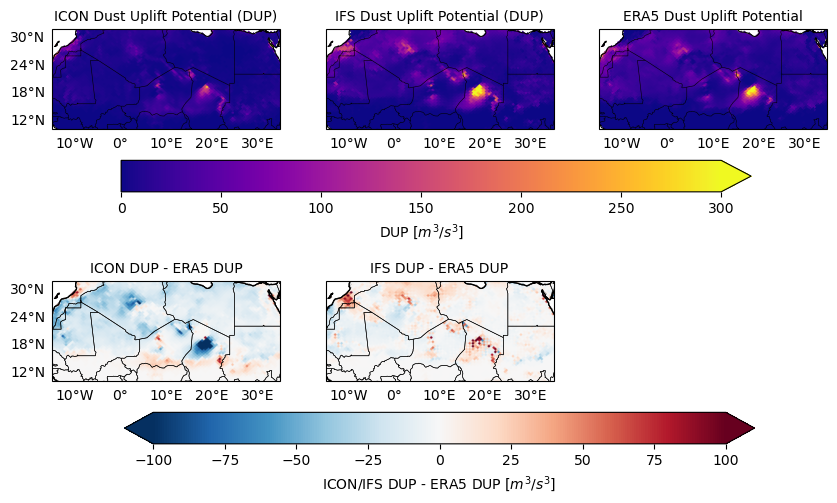

In [29]:
# Liste deiner Levels
models=["icon","ifs"]  # Beispielwerte – passe an
level=7
# Erstelle Figure und 3 Subplots mit Kartenprojektion
fig, axes = plt.subplots(
    nrows=2, ncols=3,
    figsize=(10, 6),
    subplot_kw={"projection": ccrs.PlateCarree()},
)

# Maximalwert für Farbskala definieren (gleich für alle Plots)
vmax = 300

# Schleife über Levels und Achsen
for model, ax in zip(models, axes[0,:-1]):
    # Daten laden und mitteln
    DUP_mean = xr.open_mfdataset(f"{model}_healpix/dup{level}*.nc").mean(dim="time").compute()

    # Landmaske berechnen
    land_mask = ~globe.is_ocean(DUP_mean.lat, ((DUP_mean.lon + 180) % 360) - 180)

    # Kartenausschnitt setzen
    ax.set_extent([-15, 35, 10, 32], crs=ccrs.PlateCarree())
    #ax.set_extent([15, 20, 15, 20], crs=ccrs.PlateCarree())

    # Plotten mit deiner Funktion (vermutlich healpix_show)
    im = egh.healpix_show(DUP_mean.dup.where(land_mask), ax=ax, cmap="plasma", vmax=vmax)#

    # Karten-Features hinzufügen
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)
    gl=ax.gridlines(draw_labels=True,alpha=0)
    gl.top_labels=False
    gl.right_labels=False
    if(model!="icon"):
        gl.left_labels=False
    # Titel für jedes Subplot
    ax.set_title(f"{str(model).upper()} Dust Uplift Potential (DUP)", fontsize=10)
    [0,-1]

# Gemeinsame Farbleiste unten
fig.colorbar(im, ax=axes[0,:], orientation='horizontal', location="bottom",
                    label=r"DUP [$m^3/s^3$]", extend="max")

axes[0,-1].set_extent([-15, 35, 10, 32], crs=ccrs.PlateCarree())#[-15, 35, 10, 32]

era5_DUP_mean = xr.open_mfdataset("era5_healpix/era5_dup*.nc").mean(dim="time").compute()
land_mask_era5 = ~globe.is_ocean(era5_DUP_mean.lat, ((era5_DUP_mean.lon + 180) % 360) - 180)
egh.healpix_show(era5_DUP_mean.dup.where(land_mask_era5), ax=axes[0,-1], cmap="plasma", vmax=vmax)#
axes[0,-1].add_feature(cf.COASTLINE, linewidth=0.8)
axes[0,-1].add_feature(cf.BORDERS, linewidth=0.4)
axes[0,-1].set_title(f"ERA5 Dust Uplift Potential", fontsize=10)
gl=axes[0,-1].gridlines(draw_labels=True,alpha=0)
gl.top_labels=False
gl.right_labels=False
gl.left_labels=False
# Calculate the difference
for model, ax in zip(models, axes[1,:-1]):
    # Daten laden und mitteln
    DUP_mean = xr.open_mfdataset(f"{model}_healpix/dup{level}*.nc").mean(dim="time").compute()
    DUP_mean.coarsen(cell=int(4**(level-7)),boundary="trim").mean()
    # Landmaske berechnen
    land_mask = ~globe.is_ocean(DUP_mean.lat, ((DUP_mean.lon + 180) % 360) - 180)

    # Kartenausschnitt setzen
    ax.set_extent([-15, 35, 10, 32], crs=ccrs.PlateCarree())

    
    #im = egh.healpix_show((DUP_mean.dup-era5_DUP_mean.dup).where(land_mask), ax=ax, cmap="coolwarm", vmax=vmax)
    im=plot_map_diff(
        DUP_mean.dup.where(land_mask),
        era5_DUP_mean.dup.where(land_mask_era5),
        cmap="RdBu_r",
        interpolation="bilinear",
        colorbar_label="K",
        extent=[-15, 35, 10, 32],
        ax=ax,
        vmin=-100,
        vmax=100
    )
    
    # Karten-Features hinzufügen
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)
    gl=ax.gridlines(draw_labels=True,alpha=0)
    gl.top_labels=False
    gl.right_labels=False
    if(model!="icon"):
        gl.left_labels=False
    # Titel für jedes Subplot
    ax.set_title(f"{str(model).upper()} DUP - ERA5 DUP", fontsize=10)
fig.colorbar(im, ax=axes[1,:], orientation='horizontal', location="bottom",
                    label=r"ICON/IFS DUP - ERA5 DUP [$m^3/s^3$]", extend="both")
fig.delaxes(axes[-1,-1])
fig.savefig("results/DUP_ICON_ERA5_all_levels.png", dpi=300)
plt.show()

# Seasonality

In [22]:
DUP_monthly_means = xr.open_mfdataset(f"icon_healpix/dup11*.nc").mean(dim="cell").compute()
era5_DUP_monthly_means = xr.open_mfdataset("era5_healpix/era5_dup*.nc").mean(dim="cell").compute()
months=['Jan', 'Feb', 'Mar', 'Apr', 'May',"Jun", 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

<Figure size 640x480 with 0 Axes>

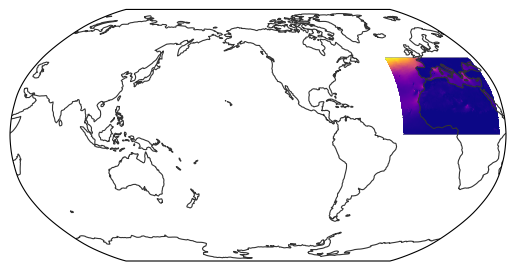

In [23]:
egh.healpix_show(xr.open_mfdataset("era5_healpix/era5_dup*.nc").dup.mean(dim="time").compute(), cmap="plasma")

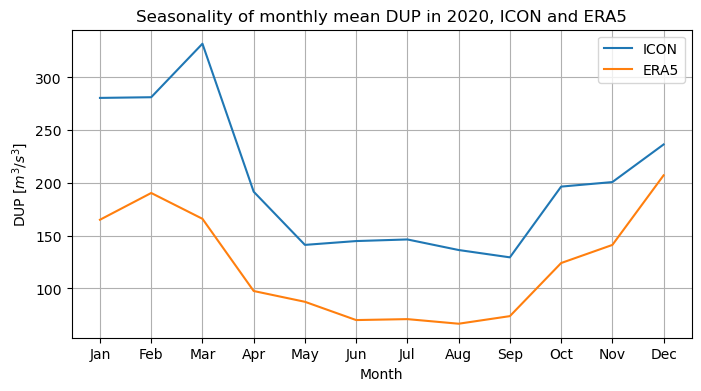

In [25]:
plt.figure(figsize=(8, 4))
plt.plot(months, DUP_monthly_means.dup,label="ICON")
plt.plot(months,era5_DUP_monthly_means.dup,label="ERA5")
plt.xlabel("Month")
plt.ylabel("DUP [$m^3/s^3$]")
plt.title("Seasonality of monthly mean DUP in 2020, ICON and ERA5")
plt.grid(True)
plt.legend()
plt.savefig("results/DUP_seasonality.pdf")
plt.show()

In [ ]:
#Now only for the land

In [27]:
DUP = xr.open_mfdataset(f"icon_healpix/dup11*.nc")
land_mask = ~globe.is_ocean(DUP.lat, ((DUP.lon + 180) % 360) - 180)
DUP_monthly_means=DUP.where(land_mask).dup.mean(dim="cell").compute()

era5_DUP = xr.open_mfdataset("era5_healpix/era5_dup*.nc")
land_mask = ~globe.is_ocean(era5_DUP.lat, ((era5_DUP.lon + 180) % 360) - 180)
era5_DUP_monthly_means=era5_DUP.where(land_mask).dup.mean(dim="cell").compute()
months=['Jan', 'Feb', 'Mar', 'Apr', 'May',"Jun", 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


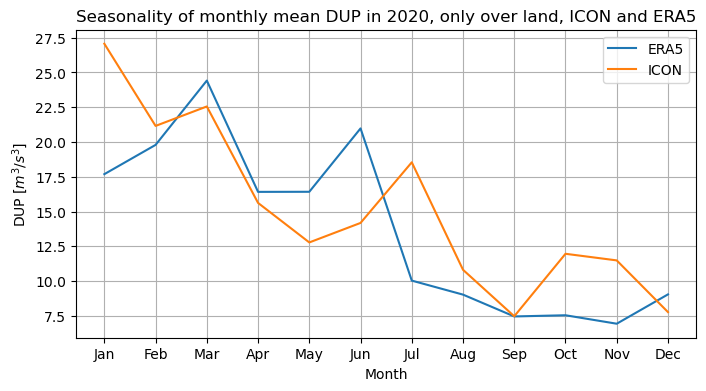

In [36]:
plt.figure(figsize=(8, 4))
plt.plot(months,era5_DUP_monthly_means,label="ERA5")
plt.plot(months, DUP_monthly_means,label="ICON")

plt.xlabel("Month")
plt.ylabel("DUP [$m^3/s^3$]")
plt.title("Seasonality of monthly mean DUP in 2020, only over land, ICON and ERA5")
plt.grid(True)
plt.legend()
#plt.ylim(0,10)
plt.savefig("results/DUP_seasonality_only_land.pdf")
plt.show()

In [29]:
DUP = xr.open_mfdataset(f"icon_healpix/dup11*.nc").groupby("time.season").mean().compute()

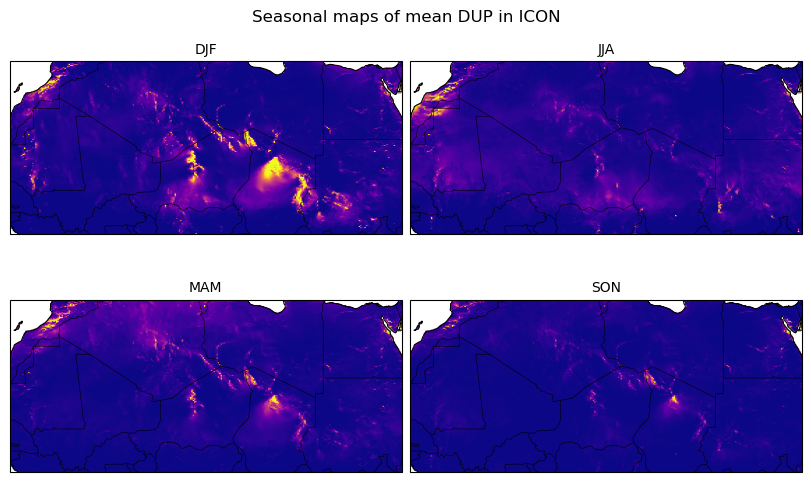

In [34]:
# Erstelle Figure und 3 Subplots mit Kartenprojektion
fig, ax = plt.subplots(
    nrows=2, ncols=2,
    figsize=(8, 5),
    subplot_kw={"projection": ccrs.PlateCarree()},
    constrained_layout=True
)

# Maximalwert für Farbskala definieren (gleich für alle Plots)
vmax = 300
seasons=['DJF', 'JJA', 'MAM', 'SON']
# Schleife über Levels und Achsen
for i in range(2):
    for j in range(2):
        
        DUP_mean = DUP.isel(season=i*2+j)
    
        # Landmaske berechnen
        land_mask = ~globe.is_ocean(DUP_mean.lat, ((DUP_mean.lon + 180) % 360) - 180)
    
        # Kartenausschnitt setzen
        ax[i,j].set_extent([-15, 35, 10, 32], crs=ccrs.PlateCarree())
        #ax.set_extent([15, 20, 15, 20], crs=ccrs.PlateCarree())
    
        # Plotten mit deiner Funktion (vermutlich healpix_show)
        im = egh.healpix_show(DUP_mean.dup.where(land_mask), ax=ax[i,j], cmap="plasma", vmax=vmax)#
    
        # Karten-Features hinzufügen
        ax[i,j].add_feature(cf.COASTLINE, linewidth=0.8)
        ax[i,j].add_feature(cf.BORDERS, linewidth=0.4)
    
        # Titel für jedes Subplot
        ax[i,j].set_title(f"{DUP.season[i*2+j].values}", fontsize=10)


# Gemeinsame Farbleiste unten
fig.colorbar(im, ax=axes[0,:], orientation='horizontal', location="bottom",
                    label=r"DUP", extend="max")
fig.suptitle("Seasonal maps of mean DUP in ICON")
fig.savefig("results/seasonal_maps.pdf")

# Mean wind speed comparison

/home/b/b383063/.local/share/mamba/envs/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


KeyboardInterrupt: 

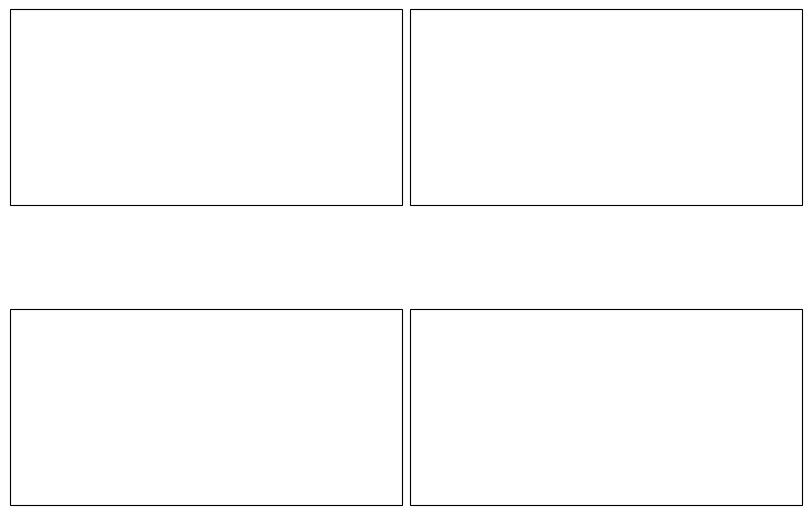

In [17]:
# Liste deiner Levels
levels = [7]  # Beispielwerte – passe an

# Erstelle Figure und 3 Subplots mit Kartenprojektion
fig, axes = plt.subplots(
    nrows=2, ncols=2,
    figsize=(8, 6),
    subplot_kw={"projection": ccrs.PlateCarree()},
    constrained_layout=True
)

# Maximalwert für Farbskala definieren (gleich für alle Plots)
vmax = 300

# Schleife über Levels und Achsen
for level, ax in zip(levels, axes[0,:-1]):
    # Daten laden und mitteln
    cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")
    experiment = cat.online["icon_d3hp003"]
    months=['Jan', 'Feb', 'Mar', 'Apr', 'May',"Jun", 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    data = experiment(time="PT3H", zoom=level).to_dask()#.chunk({"time": 1000})
    ws_mean  = data.pipe(egh.attach_coords).mean(dim="time")
    

    # Landmaske berechnen
    land_mask = ~globe.is_ocean(ws_mean.lat, ((ws_mean.lon + 180) % 360) - 180)

    # Kartenausschnitt setzen
    ax.set_extent([-60, 10, -20, 20], crs=ccrs.PlateCarree())

    # Plotten mit deiner Funktion (vermutlich healpix_show)
    im = egh.healpix_show(ws_mean.sfcwind, ax=ax, cmap="viridis")

    # Karten-Features hinzufügen
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)

    # Titel für jedes Subplot
    ax.set_title(f"DUP mean ICON, zoom={level}", fontsize=10)


# Gemeinsame Farbleiste unten
fig.colorbar(im, ax=axes[0,:], orientation='horizontal', location="bottom",
                    label=r"ws", extend="max")

axes[0,-1].set_extent([-60, 10, -20, 20], crs=ccrs.PlateCarree())

era5_ws_mean = xr.open_mfdataset("era5_healpix/era5_ws*.nc").mean(dim="time").compute()
land_mask_era5 = ~globe.is_ocean(era5_ws_mean.lat, ((era5_ws_mean.lon + 180) % 360) - 180)
egh.healpix_show(era5_ws_mean.sfcwind, ax=axes[0,-1], cmap="viridis")
axes[0,-1].add_feature(cf.COASTLINE, linewidth=0.8)
axes[0,-1].add_feature(cf.BORDERS, linewidth=0.4)
axes[0,-1].set_title(f"ws mean ERA5,zoom="+str(zoom), fontsize=10)
# Calculate the difference
for level, ax in zip(levels, axes[1,:-1]):
    # Daten laden und mitteln
    ws_mean = xr.open_mfdataset(f"icon_healpix/ws{level}*.nc").mean(dim="time").compute()
    ws_mean.coarsen(cell=int(4**(level-7)),boundary="pad").mean()
    # Landmaske berechnen
    land_mask = ~globe.is_ocean(ws_mean.lat, ((ws_mean.lon + 180) % 360) - 180)

    # Kartenausschnitt setzen
    ax.set_extent([-60, 10, -20, 20], crs=ccrs.PlateCarree())

    
    #im = egh.healpix_show((DUP_mean.dup-era5_DUP_mean.dup).where(land_mask), ax=ax, cmap="coolwarm", vmax=vmax)
    im=plot_map_diff(
        ws_mean.sfcwind,
        era5_ws_mean.sfcwind,
        cmap="RdBu_r",
        interpolation="bilinear",
        colorbar_label="K",
        extent=[-60, 10, -20, 20],
        ax=ax,
        vmin=-4,
        vmax=4
    )
    
    # Karten-Features hinzufügen
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)

    # Titel für jedes Subplot
    ax.set_title(f"ICON - ERA5, zoom={level}", fontsize=10)
fig.colorbar(im, ax=axes[1,:], orientation='horizontal', location="bottom",
                    label=r"ws difference", extend="max")
fig.savefig("results/ws_ICON_ERA5_all_levels.pdf", dpi=1000)
plt.show()

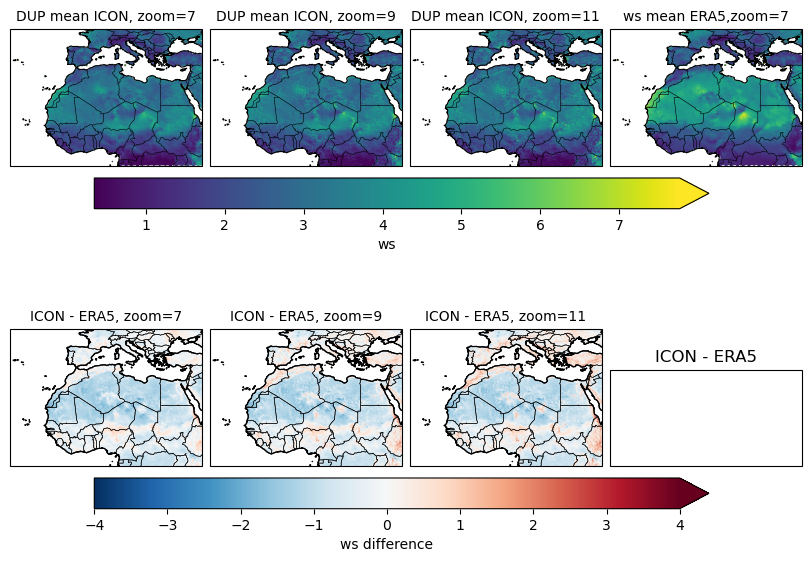

In [53]:
# Liste deiner Levels
levels = [7,9,11]  # Beispielwerte – passe an

# Erstelle Figure und 3 Subplots mit Kartenprojektion
fig, axes = plt.subplots(
    nrows=2, ncols=4,
    figsize=(8, 6),
    subplot_kw={"projection": ccrs.PlateCarree()},
    constrained_layout=True
)

# Maximalwert für Farbskala definieren (gleich für alle Plots)
vmax = 300

# Schleife über Levels und Achsen
for level, ax in zip(levels, axes[0,:-1]):
    # Daten laden und mitteln
    ws_mean = xr.open_mfdataset(f"icon_healpix/ws{level}*.nc").mean(dim="time").compute()

    # Landmaske berechnen
    land_mask = ~globe.is_ocean(ws_mean.lat, ((ws_mean.lon + 180) % 360) - 180)

    # Kartenausschnitt setzen
    ax.set_extent([-30, 40, 0, 50], crs=ccrs.PlateCarree())

    # Plotten mit deiner Funktion (vermutlich healpix_show)
    im = egh.healpix_show(ws_mean.sfcwind.where(land_mask), ax=ax, cmap="viridis")

    # Karten-Features hinzufügen
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)

    # Titel für jedes Subplot
    ax.set_title(f"DUP mean ICON, zoom={level}", fontsize=10)


# Gemeinsame Farbleiste unten
fig.colorbar(im, ax=axes[0,:], orientation='horizontal', location="bottom",
                    label=r"ws", extend="max")

axes[0,-1].set_extent([-30, 40, 0, 50], crs=ccrs.PlateCarree())

era5_ws_mean = xr.open_mfdataset("era5_healpix/era5_ws*.nc").mean(dim="time").compute()
land_mask_era5 = ~globe.is_ocean(era5_ws_mean.lat, ((era5_ws_mean.lon + 180) % 360) - 180)
egh.healpix_show(era5_ws_mean.sfcwind.where(land_mask_era5), ax=axes[0,-1], cmap="viridis")
axes[0,-1].add_feature(cf.COASTLINE, linewidth=0.8)
axes[0,-1].add_feature(cf.BORDERS, linewidth=0.4)
axes[0,-1].set_title(f"ws mean ERA5,zoom="+str(zoom), fontsize=10)
# Calculate the difference
for level, ax in zip(levels, axes[1,:-1]):
    # Daten laden und mitteln
    ws_mean = xr.open_mfdataset(f"icon_healpix/ws{level}*.nc").mean(dim="time").compute()
    ws_mean.coarsen(cell=int(4**(level-7)),boundary="pad").mean()
    # Landmaske berechnen
    land_mask = ~globe.is_ocean(ws_mean.lat, ((ws_mean.lon + 180) % 360) - 180)

    # Kartenausschnitt setzen
    ax.set_extent([-30, 40, 0, 50], crs=ccrs.PlateCarree())

    
    #im = egh.healpix_show((DUP_mean.dup-era5_DUP_mean.dup).where(land_mask), ax=ax, cmap="coolwarm", vmax=vmax)
    im=plot_map_diff(
        ws_mean.sfcwind.where(land_mask),
        era5_ws_mean.sfcwind.where(land_mask_era5),
        cmap="RdBu_r",
        interpolation="bilinear",
        colorbar_label="K",
        title=f"ICON - ERA5",
        extent=[-30, 40, 0, 50],
        ax=ax,
        vmin=-4,
        vmax=4
    )
    
    # Karten-Features hinzufügen
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)

    # Titel für jedes Subplot
    ax.set_title(f"ICON - ERA5, zoom={level}", fontsize=10)
fig.colorbar(im, ax=axes[1,:], orientation='horizontal', location="bottom",
                    label=r"ws difference", extend="max")
fig.savefig("results/ws_ICON_ERA5_all_levels.pdf", dpi=1000)
plt.show()

In [149]:
import xarray as xr
import intake
cat=intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")
experiment = cat.online["icon_d3hp003"]
ifs_11 = experiment(time="PT3H", zoom=11).to_dask()#.chunk({"time": 1000})
ifs_7 = experiment(time="PT3H", zoom=7).to_dask()#.chunk({"time": 1000})
#ifs_11 = xr.open_dataset("https://s3.eu-dkrz-1.dkrz.cloud/wrcp-hackathon/data/IFS-FESOM/hourly_healpix2048.zarr", chunks='auto', engine="zarr")
#ifs_7 = xr.open_dataset("https://s3.eu-dkrz-1.dkrz.cloud/wrcp-hackathon/data/IFS-FESOM/hourly_healpix128.zarr", chunks='auto', engine="zarr")
 
tstart = "20200101"
tend = "20200102"

ifs7_tas = ifs_7.tas.sel(time=slice(tstart, tend)).mean("time").load()
ifs11_tas = ifs_11.tas.sel(time=slice(tstart, tend)).mean("time").load()

/home/b/b383063/.local/share/mamba/envs/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home/b/b383063/.local/share/mamba/envs/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [150]:
# you can coarsen the dataset directly - each coarsening by 4 will reduce the data by one zoom level
ifs_tas_hp10 = ifs11_tas.coarsen(cell=4).mean()  # 11 => 10
ifs_tas_hp7 = ifs11_tas.coarsen(cell=4**4).mean()  # 11 => 7

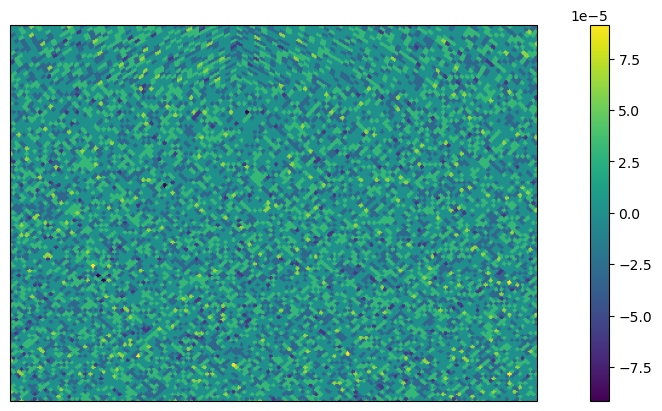

In [153]:
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(
    figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
)
ax.set_extent([-30, 40, 0, 50], crs=ccrs.PlateCarree())
im=egh.healpix_show(ifs_tas_hp7 - ifs7_tas)
fig.colorbar(im)